<a href="https://colab.research.google.com/github/Sadatul99/ostad-course/blob/main/m2_AI_Agent_102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langgraph langsmith langchain-groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.7.0 which is incompatible.


In [ ]:
groq_api_key = ""

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [ ]:
class State(TypedDict):
    message: Annotated[list, add_messages]

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-20b", groq_api_key=groq_api_key)


In [ ]:
llm.invoke("what is langgraph")

AIMessage(content="LangGraph is a Python library built on top of LangChain that allows you to create **stateful, multi-actor conversational applications** using graphs. Think of it as a way to orchestrate complex interactions between different agents, tools, and data sources in a structured and reliable manner.\n\nHere's a breakdown of what makes LangGraph important and its key features:\n\n**Core Concepts:**\n\n* **Stateful Graphs:**  Unlike simple chains that execute linearly, LangGraph maintains a state throughout the conversation. This state is a Python dictionary that can be updated and accessed by different nodes in the graph. This allows agents to remember past interactions and make decisions based on the entire conversation history.\n\n* **Nodes:**  Nodes are the building blocks of your graph. They represent individual steps in the conversation flow.  Nodes can be:\n    * **Agents:**  LangChain agents that use LLMs to make decisions and take actions.\n    * **Functions/Tools:**

In [ ]:
def chatbot(state:State):
    return {"message": [llm.invoke(state["message"])]}

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("llmchatbot", chatbot)

graph_builder.add_edge(START, "llmchatbot")

graph_builder.add_edge("llmchatbot", END)

graph=graph_builder.compile()

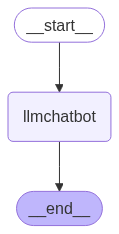

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
response = graph.invoke({"message": "Hi"})
response

{'message': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='a2f7d2c1-0525-42c8-af32-5ee208b793ad'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'We need to respond politely. Probably a greeting.'}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 72, 'total_tokens': 101, 'completion_time': 0.025858833, 'prompt_time': 0.005199936, 'queue_time': 0.276366164, 'total_time': 0.031058769}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_4c4aa6a4a4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--fef20b22-e747-4dcb-8d7a-050d2de0a4fb-0', usage_metadata={'input_tokens': 72, 'output_tokens': 29, 'total_tokens': 101})]}

# TOOL Calling

In [ ]:
# four components
# name
# description
# args
# functionalities
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """This function is responsible for multiplication"""
    return a*b

In [ ]:
multiply.invoke({"a":2,"b":5})

10

In [ ]:
multiply.name

'multiply'

In [ ]:
multiply.description

'This function is responsible for multiplication'

In [ ]:
multiply.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [ ]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [ ]:
tools = [multiply, sumX]

llm = ChatGroq(model="openai/gpt-oss-20b", groq_api_key=groq_api_key)
llm_with_tool = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def tool_calling_llm(state: State):
    return {
        "messages": [llm_with_tool.invoke(state["messages"])]
    }

In [ ]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78fa5fb48f50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78fa5fb3bbf0>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'This function is responsible for multiplication', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'sumX', 'description': 'This function is responsible for addition', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges("tool_calling_llm", tools_condition)
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()

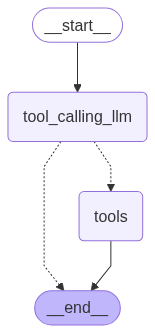

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
response = graph.invoke({
    "messages": [HumanMessage(content="please addition 3 and 4")]
})
print(response)

{'messages': [HumanMessage(content='please addition 3 and 4', additional_kwargs={}, response_metadata={}, id='13af6f24-aefb-4376-b1c1-23e31aa5bfeb'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call sumX with a=3, b=4.', 'tool_calls': [{'id': 'fc_1f477dee-3230-4f06-9c15-cbd2d388e2ab', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'sumX'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 156, 'total_tokens': 199, 'completion_time': 0.038627602, 'prompt_time': 0.010095875, 'queue_time': 0.18496234, 'total_time': 0.048723477}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_ebaf47239f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bc4ed022-0623-4692-90f3-c64de648da3c-0', tool_calls=[{'name': 'sumX', 'args': {'a': 3, 'b': 4}, 'id': 'fc_1f477dee-3230-4f06-9c15-cbd2d388e2ab', 'type': 'tool_call'}], usage_metadata={'input_tokens': 156, 'output_tokens':

In [ ]:
response

{'messages': [HumanMessage(content='please addition 3 and 4', additional_kwargs={}, response_metadata={}, id='13af6f24-aefb-4376-b1c1-23e31aa5bfeb'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call sumX with a=3, b=4.', 'tool_calls': [{'id': 'fc_1f477dee-3230-4f06-9c15-cbd2d388e2ab', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'sumX'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 156, 'total_tokens': 199, 'completion_time': 0.038627602, 'prompt_time': 0.010095875, 'queue_time': 0.18496234, 'total_time': 0.048723477}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_ebaf47239f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bc4ed022-0623-4692-90f3-c64de648da3c-0', tool_calls=[{'name': 'sumX', 'args': {'a': 3, 'b': 4}, 'id': 'fc_1f477dee-3230-4f06-9c15-cbd2d388e2ab', 'type': 'tool_call'}], usage_metadata={'input_tokens': 156, 'output_tokens

In [ ]:
from langchain_core.messages import ToolMessage

tool_outputs = [
    m.content for m in response["messages"] if isinstance(m, ToolMessage)
]
print(tool_outputs)
print(tool_outputs[0])


['12']
12
